![QuantConnect Logo](https://cdn.quantconnect.com/web/i/logo-small.png)


## Pairs Trading Based on Cointegration

Pairs trading is a market neutral trading strategy and it belongs to statistical arbitrage. The basic idea is to select two stocks which move similarly, sell the high priced stock and buy the low priced stock where there is a price divergence between the pairs.

- Check the algorithm implemented on LEAN

https://www.quantconnect.com/terminal/processCache?request=embedded_backtest_beb5b38bb307c677d9611dc48bc38db9.html

In [9]:
%matplotlib inline
# Imports
from clr import AddReference
AddReference("System")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Jupyter")
AddReference("QuantConnect.Indicators")
from System import *
from QuantConnect import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Jupyter import *
from QuantConnect.Indicators import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
# Create an instance
qb = QuantBook()

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import statsmodels.api as sm
from math import floor
plt.style.use('seaborn-whitegrid')
from sklearn import linear_model

### Cointegration
Before using pairs trading, we need to know the cointegration. Cointegration is a statistical property of time series (that is a series of random variables)

- Correlation specify the co-movement of return, it is a short-term relationship

- Cointegration specify co-movement of price, it is a long-term relationship

Generally speaking, the weak stationary process means the mean and the autocovariance do not vary over time. For example, white noise $\epsilon_t$ is an example of stationary time series because $E(\epsilon_t)=0$ and $Var(\epsilon_t)=\sigma^2$. 

If two series {$x_t$} and {$y_t$} are not stationary but their linear combination $ u_t = \beta x_t - y_t$ is a stationary process, then we say {xt} and {yt} are cointegrated. Here we take the first-order difference of x and y, then we say their relationship is first-order cointegration. Most of the financial time series are integrated of order 1.

In general, we use Augmented Dickey-Fuller test to test cointegration.

### Step 1:  Find two likely cointegrated stocks
Two stocks we choose here is XOM and CVX. They are two American multinational oil and gas corporations. They are of the same industry.


In [35]:
syls = ["XOM","CVX"]
qb.AddEquity(syls[0])
qb.AddEquity(syls[1])
start = datetime(2003,1,1)
end = datetime(2009,1,1)
x = qb.History(syls[0],start ,end, Resolution.Daily).loc[syls[0]]['close']
y = qb.History(syls[1],start ,end, Resolution.Daily).loc[syls[1]]['close']

In [36]:
price = pd.concat([x, y], axis=1)
price.columns = syls 
lp = np.log(price)

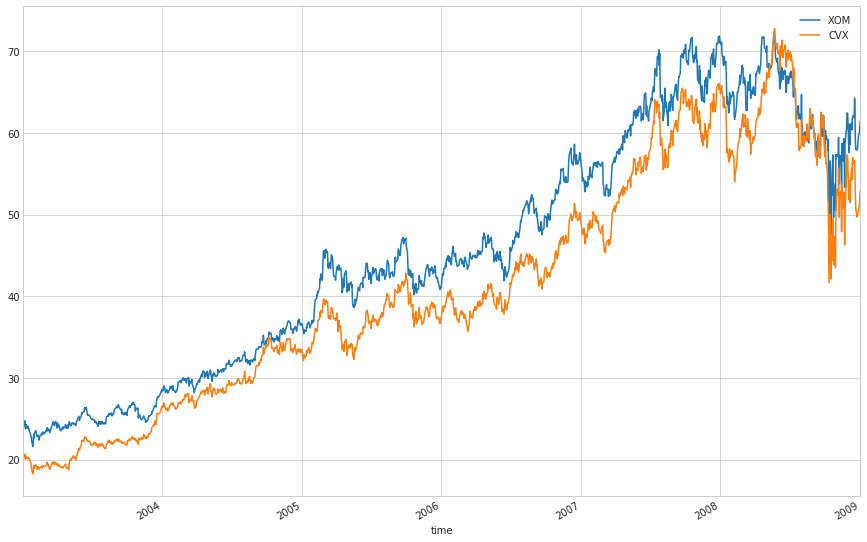

In [37]:
price.plot(figsize = (15,10))

### Step 2: Estimate Spreads
If we have two stocks, X & Y, that are cointegrated in their price movements, then any divergence in the spread from 0 should be temporary and mean-reverting. Next step we will estimate the spread series.

In [38]:
def reg(x,y):
    regr = linear_model.LinearRegression()
    x_constant = pd.concat([x,pd.Series([1]*len(x),index = x.index)], axis=1)
    regr.fit(x_constant, y)    
    beta = regr.coef_[0]
    alpha = regr.intercept_
    spread = y - x*beta - alpha
    return spread

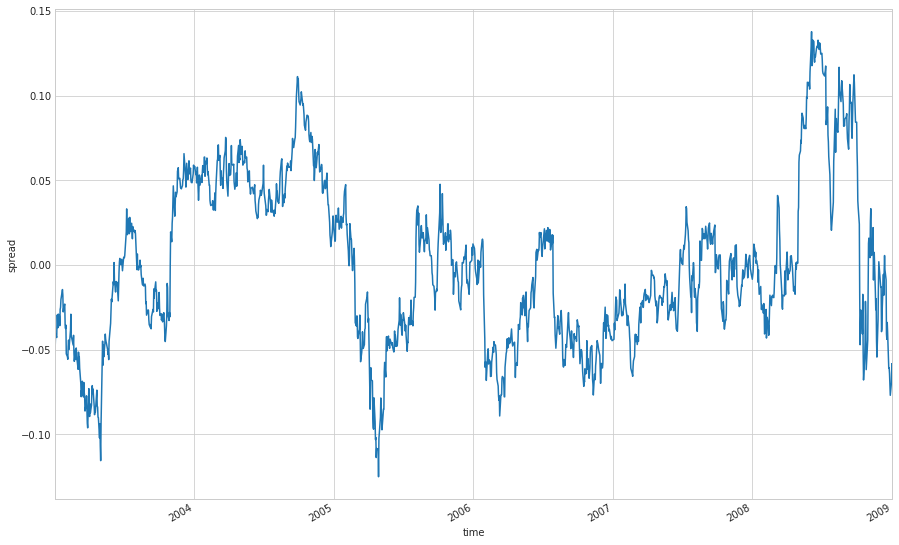

In [39]:
x = lp['XOM']
y = lp['CVX']
spread = reg(x,y)
# plot the spread series
spread.plot(figsize =(15,10))
plt.ylabel('spread')

### Step 3: Check Staionarity
From the above plot, the first order difference $Spread_t=log(y_t) -\beta log(x_t)-\alpha$ seems to be staionary and mean-reversion. Next we will check if it is staionary. We use ADF test to check the stationary of the spread series.

In [40]:
# check if the spread is stationary 
adf = sm.tsa.stattools.adfuller(spread, maxlag=1)
print 'ADF test statistic: %.02f' % adf[0]
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
print 'p-value: %.03f' % adf[1]

ADF test statistic: -3.45
	5%: -2.863
	1%: -3.435
	10%: -2.568
p-value: 0.009


Running the example prints the test statistic value of -3.45. The more negative this statistic, the more likely we are to reject the null hypothesis (there is a unit root).

As part of the output, we get a table to help determine the ADF statistic. We can see that our statistic value of -3.45 is less than the value of -3.435 at 1%. The p-value 0.009 is less than 0.05.

This suggests that we can reject the null hypothesis with a significance level of less than 5%. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

### Step 4: Create Trading Signal
Here we use 1.5 times the standard deviation as our threshold. If the sample is out of this range, then we think there is a price divergence between these two stocks price which means we capture a pairs trading opportunity. The rolling window of the history close price over 250 days are used to perform the regression. 

For trading strategy development we use LEAN API to implement.
> https://www.quantconnect.com/terminal/processCache?request=embedded_backtest_beb5b38bb307c677d9611dc48bc38db9.html